## We have previously trained AE models for the BOOSTED TOP dataset since the basis (CMS Detector) remains same we expect them to work well for the TOP_GUN dataset too. This notebook tests that hypothesis.

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import timm
import numpy as np
import torch.nn as nn
import torch
from torchvision import datasets, models, transforms
import torchvision
from torchvision.utils import make_grid
from typing import Any
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import pyarrow.parquet as pq
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn import metrics
import gc
import os 
import torch
import torch.nn as nn
import sys
import pandas as pd
import wandb
import glob

from einops import rearrange
from einops.layers.torch import Rearrange
import PIL.Image as Image
import PIL as pil
import time
import einops
import pandas as pd
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import data
import models

import h5py

In [125]:
data_file.close()

## Reading and displaying the jets

In [130]:
#Index 0 is Invariant Mass and Index 2 is PT
CHUNK_SIZE = 32
BATCH_SIZE = 512
FILE_PATH = '/pscratch/sd/d/diptarko/SYMMETRY/TOP_GUN/assets/DATA/Regression_AM.h5'
data_file = h5py.File('/pscratch/sd/d/diptarko/SYMMETRY/TOP_GUN/assets/DATA/Regression_AM.h5', 'r')
dataset = data.Jet_Dataset(file_path=FILE_PATH,
                           chunk_size = CHUNK_SIZE,
                           MODE = "LATENT"
                          )
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE//CHUNK_SIZE,
                                         shuffle=False,
                                         drop_last = True,
                                         num_workers=8,
                                         pin_memory = True,
                                         collate_fn=data.collate_with_shuffle_latent
                                        )

In [131]:
# train_tensor = data_file["latent"][:,...]
train_meta = data_file["meta"][:,...]

In [120]:
BATCH_SIZE = 128
dataset = h5py.File('/pscratch/sd/d/diptarko/SYMMETRY/TOP_GUN/assets/DATA/Regression_AM.h5', 'r')
NO_SAMPLES = dataset["meta"].shape[0]
try:
    data_chunk_latent = dataset.create_dataset("latent", (NO_SAMPLES,8,1024),chunks=(1,8,1024))
except Exception as e: 
    if e.__str__().count("name already exists") <1:
        print("WARNING:",e)
        
BATCH_SIZE = 128
ae = [models.auto_encoder(in_channels=1,out_channels=1, init_features=32) for i in range(8)]
for i in range(8):
    ae[i].load_state_dict(torch.load(f"./assets/Latent/weights/{i}/model_Epoch_10.pt",map_location="cpu")["model_state_dict"])
    ae[i] = ae[i].to("cuda:0")
    
NO_SAMPLES = dataset["jet"].shape[0]

for i in tqdm(range(0,NO_SAMPLES//BATCH_SIZE+1)):
    im = dataset["jet"][i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    im = torch.tensor(im).float().to(device)
    im = nn.functional.pad(im, (2,1,2,1))
    lat = [ae[j].encoder(im[:,[j],:,:]).to("cpu").squeeze().detach().numpy()[:,None,:] for j in range(8)]
    lat = np.concatenate(lat,axis = 1)
    train_tensor[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:,:] = lat
print("---------DONE---------")

100%|██████████| 8219/8219 [15:00<00:00,  9.13it/s]

---------DONE---------


In [127]:
np.save("./latent.npy",train_tensor)

In [ ]:
train_dataset = TensorDataset(X_train,Y_train)
train_dataloader = DataLoader(train_dataset,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

In [178]:
device = "cuda:0"
LATENT_DIM = 1024
NUM_GENERATORS = 4

In [179]:
model_fe = models.MLP(feature_size=LATENT_DIM).to(device)
model_fd = models.MLP(feature_size=LATENT_DIM).to(device)
# model_fo = models.LatentOracle().to(device)
model_fo = models.LatentOracle().to(device)

model_symmetry = models.GroupLatent(num_features=LATENT_DIM,num_generators=NUM_GENERATORS).to(device)

optimiser_fe = torch.optim.Adam(model_fe.parameters(), lr = 1e-3)
optimiser_fd = torch.optim.Adam(model_fd.parameters(), lr = 1e-3)
optimiser_fo = torch.optim.Adam(model_fo.parameters(), lr = 1e-3)
optimiser_symmetry = torch.optim.Adam(model_symmetry.parameters(), lr = 1e-3)


criterion_mse = nn.MSELoss()

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [146]:
torch.flatten(torch.randn(128,8,1024),start_dim = 1,end_dim = 2).shape

torch.Size([128, 8192])

In [151]:
train_dataset = torch.utils.data.TensorDataset(torch.flatten(torch.tensor(train_tensor),start_dim = 1,end_dim = 2),
                                               torch.tensor(train_meta[:,0]))
train_dataloader = DataLoader(train_dataset,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

In [180]:
class MLP(nn.Module):

    def __init__(self, in_features, width_mul=1, drop_rate = 0.2):
        super(MLP, self).__init__()
        self.drop_rate = drop_rate
        self.block1 = self.block(in_features, in_features*width_mul, name="block1")
        self.block2 = self.block(in_features*width_mul, in_features*width_mul, name="block2")
        self.block3 = self.block(in_features*width_mul, in_features, name="block3")
        self.head = nn.Linear(in_features=in_features,out_features=1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.head(x)

        return x.squeeze()


    # @staticmethod
    def block(self,in_features,out_features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "linear1",
                        nn.Linear(
                            in_features=in_features,
                            out_features=out_features,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm1d(num_features=out_features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (name + "drop1", nn.Dropout(self.drop_rate))
                ]
            )
        )


In [181]:
model_fo = MLP(in_features = 1024).to(device)
optimiser_fo = torch.optim.Adam(model_fo.parameters(), lr = 1e-3)

In [160]:
loss_S_closure = []
loss_S_orth = []
loss_S_collapse = []

loss_space = []
loss_oracle = []
c = []
for i in range(300):
    
    loss_S_closure_ = 0
    loss_S_orth_ = 0
    loss_S_collapse_ = 0

    loss_space_ = 0
    loss_oracle_ = 0
    
    label_list = []
    outputs_list = []
    
    for Z,M, in tqdm(train_dataloader):
        Z = Z.to(device)
        M = M.to(device)
        
        # optimiser_fd.zero_grad()
        # optimiser_fe.zero_grad()
        optimiser_fo.zero_grad()
        # optimiser_symmetry.zero_grad()

        # theta = [(2*torch.rand(Z.shape[0],device = device) - 1) for i in range(NUM_GENERATORS)]  #Sampling

        # P = model_fe(Z)
        # P_S = model_symmetry(theta = theta, x = P)
        # Z_S = model_fd(P_S)
        m = model_fo(Z)
        # m_S = model_fo(Z_S)
        # Z_P = model_fd(P)

        # loss1 = criterion_mse(m_S,m)
        # loss2 = model_symmetry.orthogonal_loss()
        # loss3 = model_symmetry.collapse_loss()
        # loss5 = criterion_mse(Z,Z_P)
        loss6 = criterion_mse(m,M)
        
        # loss_S = loss1 + loss2 + loss3
        # loss_Ae = loss5
        # loss_Ae = loss5 + loss1 # Testing ...
        loss_O = loss6
        
        # loss_S.backward(retain_graph=True)
        # loss_Ae.backward(retain_graph=True)
        loss_O.backward(retain_graph=True)
        
        
        
        # optimiser_fd.step()
        # optimiser_fe.step()
        optimiser_fo.step()
        # optimiser_symmetry.step()
    
        
#         loss_S_closure_ += loss1.item()
#         try:
#             loss_S_orth_ += loss2.item()
#         except AttributeError:
#             loss_S_orth_ = 0

#         loss_S_collapse_ += loss3.item()

#         loss_space_ += loss5.item()
        loss_oracle_ += loss6.item()
        label_list.extend(M.detach().cpu().numpy())
        outputs_list.extend(m.detach().cpu().numpy())
    
#     loss_S_closure_ /= len(dataloader)
#     loss_S_orth_ /= len(dataloader)
#     loss_S_collapse_ /= len(dataloader)

#     loss_space_ /= len(dataloader)
    loss_oracle_ /= len(dataloader)
    
    
#     loss_S_closure.append(loss_S_closure_)
#     loss_S_collapse.append(loss_S_collapse_)
#     loss_S_orth.append(loss_S_orth_)
    
#     loss_space.append(loss_space_)
    loss_oracle.append(loss_oracle_)
    
    print(f"EPOCH {i} complete")
    print("=====================")
#     print("Symmetry Closure Loss ",loss_S_closure_)
#     print("Symmetry Orthogonality Loss ",loss_S_orth_)
#     print("Symmetry Collapse Loss ",loss_S_collapse_)
    
#     print("Space Inversion Loss ",loss_space_)
    print("Oracle loss",loss_oracle_)
    print("=====================")
    

100%|██████████| 2054/2054 [02:02<00:00, 16.73it/s]


EPOCH 0 complete
Oracle loss 3149.5659341338546


100%|██████████| 2054/2054 [01:59<00:00, 17.15it/s]


EPOCH 1 complete
Oracle loss 2619.6101537182594


100%|██████████| 2054/2054 [01:59<00:00, 17.20it/s]


EPOCH 2 complete
Oracle loss 2237.9604915927193


100%|██████████| 2054/2054 [02:04<00:00, 16.47it/s]


EPOCH 3 complete
Oracle loss 1971.1243059702485


 18%|█▊        | 365/2054 [00:37<02:52,  9.82it/s]


KeyboardInterrupt: 

In [76]:
M

tensor([[135.2198],
        [347.4708],
        [289.7751],
        ...,
        [109.8932],
        [472.1400],
        [159.5949]], device='cuda:0')

In [155]:
len(label_list)

1051648

In [156]:
len(outputs_list)

1051648

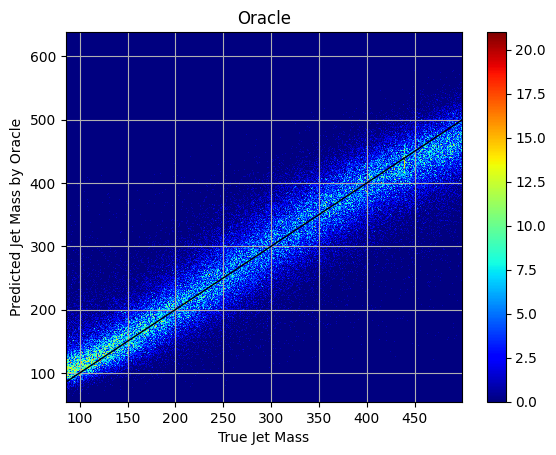

In [162]:
plt.tight_layout()
plt.grid(True)
plt.xlabel("True Jet Mass")
plt.ylabel("Predicted Jet Mass by Oracle")
plt.title("Oracle")
plt.hist2d(label_list,outputs_list, (500, 500), cmap=plt.cm.jet)
plt.colorbar()
# plt.xlim(40,300)
# plt.ylim(40,300)
plt.plot([0,500],[0,500], linewidth = 1, c="black")

In [50]:
((M - M.mean())**2).mean()

tensor(14224.3281, device='cuda:0')

In [ ]:
loss_S_closure = []
loss_S_orth = []
loss_S_collapse = []

loss_space = []
loss_oracle = []
c = []
for i in range(300):
    
    loss_S_closure_ = 0
    loss_S_orth_ = 0
    loss_S_collapse_ = 0

    loss_space_ = 0
    loss_oracle_ = 0
    
    for Z,M in tqdm(train_dataloader):
        Z = Z[:,:1024].to(device)
        M = M.to(device)
        
        optimiser_fd.zero_grad()
        optimiser_fe.zero_grad()
        optimiser_fo.zero_grad()
        optimiser_symmetry.zero_grad()

        theta = [(2*torch.rand(Z.shape[0],device = device) - 1) for i in range(NUM_GENERATORS)]  #Sampling

        P = model_fe(Z)
        P_S = model_symmetry(theta = theta, x = P)
        Z_S = model_fd(P_S)
        m = model_fo(Z)
        m_S = model_fo(Z_S)
        Z_P = model_fd(P)

        loss1 = criterion_mse(m_S,m)
        loss2 = model_symmetry.orthogonal_loss()
        loss3 = model_symmetry.collapse_loss()
        loss5 = criterion_mse(Z,Z_P)
        loss6 = criterion_mse(m,M)
        
        loss_S = loss1 + loss2 + loss3
        # loss_Ae = loss5
        loss_Ae = loss5 + loss1 # Testing ...
        loss_O = loss6
        
        loss_S.backward(retain_graph=True)
        loss_Ae.backward(retain_graph=True)
        loss_O.backward(retain_graph=True)
        
        
        
        optimiser_fd.step()
        optimiser_fe.step()
        optimiser_fo.step()
        optimiser_symmetry.step()
    
        
        loss_S_closure_ += loss1.item()
        try:
            loss_S_orth_ += loss2.item()
        except AttributeError:
            loss_S_orth_ = 0

        loss_S_collapse_ += loss3.item()

        loss_space_ += loss5.item()
        loss_oracle_ += loss6.item()
    
    loss_S_closure_ /= len(dataloader)
    loss_S_orth_ /= len(dataloader)
    loss_S_collapse_ /= len(dataloader)

    loss_space_ /= len(dataloader)
    loss_oracle_ /= len(dataloader)
    
    
    loss_S_closure.append(loss_S_closure_)
    loss_S_collapse.append(loss_S_collapse_)
    loss_S_orth.append(loss_S_orth_)
    
    loss_space.append(loss_space_)
    loss_oracle.append(loss_oracle_)
    
    print(f"EPOCH {i} complete")
    print("=====================")
    print("Symmetry Closure Loss ",loss_S_closure_)
    print("Symmetry Orthogonality Loss ",loss_S_orth_)
    print("Symmetry Collapse Loss ",loss_S_collapse_)
    
    print("Space Inversion Loss ",loss_space_)
    print("Oracle loss",loss_oracle_)
    print("=====================")
    

 24%|██▍       | 496/2054 [00:32<01:01, 25.50it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f60ac4f3940>
Traceback (most recent call last):
  File "/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f60ac4f3940>
Traceback (most recent call last):
  File "/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478,

EPOCH 0 complete
Symmetry Closure Loss  265.7471162911864
Symmetry Orthogonality Loss  0.11298270031679222
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.4177147287081024
Oracle loss 16343.556514632272


 42%|████▏     | 868/2054 [00:52<00:46, 25.35it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f60ac4f3940>
Traceback (most recent call last):
  File "/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f60ac4f3940>
Traceback (most recent call last):
  File "/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478,

EPOCH 1 complete
Symmetry Closure Loss  236.11851329116303
Symmetry Orthogonality Loss  0.06652910013872669
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.102334997321986
Oracle loss 9782.483705336766


  0%|          | 0/2054 [00:00<?, ?it/s]

In [35]:
loss1

tensor(932.7210, device='cuda:0', grad_fn=<MseLossBackward0>)

In [175]:
Z.shape

torch.Size([512, 1024])

In [9]:
m_S.shape

torch.Size([1024, 1])

In [42]:
m_S

tensor([[289.7299],
        [289.7145],
        [289.7177],
        ...,
        [289.7147],
        [289.7155],
        [289.7158]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [44]:
m

tensor([[271.6432],
        [310.8359],
        [258.4042],
        ...,
        [309.3478],
        [284.9797],
        [332.0737]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [45]:
M

tensor([[187.2240],
        [379.2007],
        [141.8650],
        ...,
        [162.5331],
        [429.4339],
        [264.3044]], device='cuda:0')

In [14]:
Z[:,:1024].shape

torch.Size([1024, 1024])

In [17]:
len(dataloader)

1027

In [41]:
loss6

tensor(12298.9629, device='cuda:0', grad_fn=<MseLossBackward0>)

In [27]:
loss_S_closure_

172883.42483041715

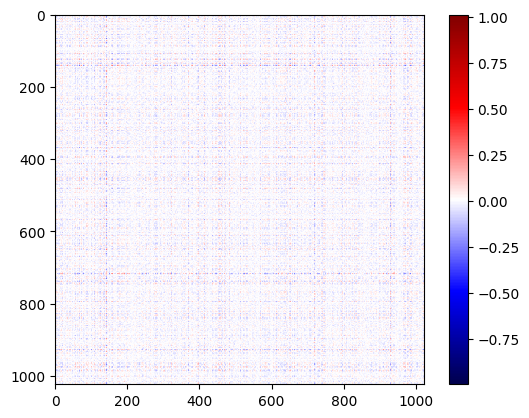

In [28]:
plt.imshow(model_symmetry.group[0].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

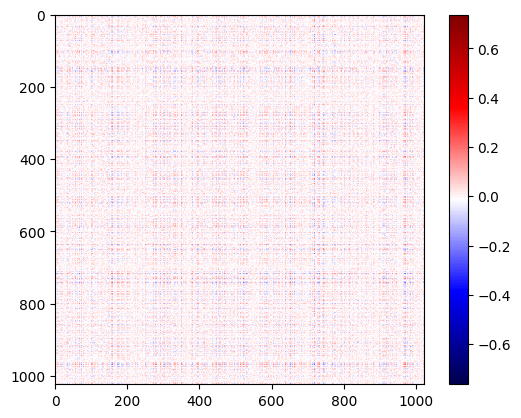

In [29]:
plt.imshow(model_symmetry.group[1].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()